# Benchmark Comparisons

Compare my implementations and Spinning Up versions of RL algos on MuJoCo Gym tasks.
https://spinningup.openai.com/en/latest/spinningup/bench.html

In [1]:
import glob, os, sys
import pandas as pd
import plotnine as pn
DATA_DIR = '/Users/kurtsmith/research/spinningup/data'
pd.options.display.max_columns=None

In [2]:
def get_full_data(task_list, method_list):
    output_paths = {}
    full_data = {}
    for task in task_list:
        output_paths[task] = {}
        full_data[task] = {}
        for method in method_list:
            my_path = f'{DATA_DIR}/{task}/{method}'
            if os.path.exists(my_path):
                output_paths[task][method] = os.listdir(my_path)
    for task in task_list:
        for method in output_paths[task].keys():
            results = []
            for run_num in output_paths[task][method]:
#                 print(f'{task} {method} {run_num}')
                progress = pd.read_table(f'{DATA_DIR}/{task}/{method}/{run_num}/progress.txt')
                progress['Minutes'] =  progress['Time']/60.
                progress['Hours'] =  progress['Time']/60./60.
                progress['task'] = task
                progress['method'] = method
                progress['run'] = run_num
                results.append(progress)
            if len(results)>0:
                full_data[task][method] = pd.concat(results)
    return full_data

In [3]:
task_list = ['walker2d_v3', 'ant_v3', 'hopper_v3', 'halfcheetah_v3',  'swimmer_v3']
method_list = ['su_ddpg', 'ddpg', 'su_td3', 'td3', 'su_sac', 'sac', 'su_ppo', 'ppo']
full_data = get_full_data(task_list, method_list)

In [1165]:
# def plot_run_returns(df, col=None, task=None, method=None, line=True, points=False):
#     if col is None:
#         col = 'AverageTestEpRet' if 'AverageTestEpRet' in df.columns else 'AverageEpRet'
#     plot = pn.ggplot(df, pn.aes(x='TotalEnvInteracts', y=col))
#     if line:
#         plot += pn.geom_line(pn.aes(color='run'))
#     if points:
#         plot += pn.geom_point(pn.aes(color='run'))
#     if task is not None:
#         plot += pn.labels.ggtitle(f'{task} : {method}')        
#     return plot

# def plot_smoothed_returns(df, window_size, plot=True, label='smoothed', **kwargs):
#     df_smooth = df.groupby('TotalEnvInteracts').mean().reset_index()
#     df_smooth = df_smooth.rolling(window_size).mean()
#     df_smooth = df_smooth.dropna()
#     df_smooth['run'] = label
#     if plot:
#         return plot_run_returns(df_smooth, **kwargs)
#     else:
#         return df_smooth

# def compare_runs(task, full_data=full_data, **kwargs):
#     for method in full_data[task].keys():
#         display(plot_run_returns(full_data[task][method], task=task, method=method, **kwargs))

# def compare_smoothed_returns(task, full_data=full_data, **kwargs):
#     for method in full_data[task].keys():
#         if not 'su_' in method:
#             df_mine = plot_smoothed_returns(full_data[task][method], 4, plot = False, label='Mine')
#             df_su = plot_smoothed_returns(full_data[task]['su_' + method], 4, plot = False, label='Spinning Up')
#             display(plot_run_returns(pd.concat((df_mine, df_su)),
#                                      task=task, method=method, points=True, **kwargs))

In [4]:
def process_data(df_orig, x_col = 'TotalEnvInteracts', col='AverageTestEpRet', window_size=None, avg=False, label='run_average'):
    """Processes data using window averaging, average over runs, and confidence interval """
    df = df_orig.sort_values(['run', x_col])
    if window_size is not None:
        df = df.groupby('run').rolling(window_size).mean().dropna().reset_index()
    if avg:
        df = df.groupby(x_col).agg({col : ['mean', 'sem']}) 
        df.columns = [col, 'sem']
        df = df.reset_index()
        df['ymin'] = df[col] - 1.96*df['sem']
        df['ymax'] = df[col] + 1.96*df['sem']
        df['run'] = label
    return df

def plot_runs(df, task=None, method=None, x_col = 'TotalEnvInteracts', col='AverageTestEpRet', points=True, **kwargs):
    """Plot all runs from a df for specified task/method."""
    if not col in df.columns:
        col = col.replace('Test', '')    
    df = process_data(df, avg=False, x_col=x_col, col=col, **kwargs)
    plot = pn.ggplot(df, pn.aes(x=x_col, y=col, color='run')) + pn.geom_line()
    if points:
        plot += pn.geom_point()
    plot += pn.labels.ggtitle(f'{task} : {method}')   
    display(plot)

def plot_runs_all_methods(df, task, **kwargs):
    """Loop over all methods for specified task. Plot all runs for each method."""
    for method in df[task].keys():
        plot_runs(df[task][method], task=task, method=method, **kwargs)

def plot_compare_methods(df, task, method, x_col = 'TotalEnvInteracts', col='AverageTestEpRet', **kwargs):
    """Plot my implementation vs Spinning Up (avg over runs) for a specified task/method."""
    if not col in df[task][method].columns:
        col = col.replace('Test', '')        
    df_mine = process_data(df[task][method], avg=True, label='Mine', x_col=x_col, col=col, **kwargs)
    df_su = process_data(df[task]['su_' + method], avg=True, label='Spinning Up', x_col=x_col, col=col, **kwargs)
    df = pd.concat((df_mine, df_su))
    plot = pn.ggplot(df, pn.aes(x=x_col, y=col, color='run')) + pn.geom_point() + pn.geom_line() + pn.geom_errorbar(
        pn.aes(ymin='ymin', ymax='ymax'), alpha=0.5)
    plot += pn.labels.ggtitle(f'{task} : {method}')   
    display(plot)

def compare_all_methods(full_data, **kwargs):
    """Plot my implementation vs Spinning Up for all methods for a specified task."""
    for method in full_data[task].keys():
        if not 'su_' in method:
            plot_compare_methods(full_data, task, method, **kwargs)

In [1167]:
# def get_mean_with_ci(df, window_size, label='smoothed'):
#     x_col = 'TotalEnvInteracts'
#     col='AverageTestEpRet'
#     df_smoothed_runs = df.sort_values(['run', 'Epoch'])
#     df_smoothed_runs = df_smoothed_runs.groupby('run').rolling(window_size).mean().dropna().reset_index()
# #     df_smoothed_runs = df.rolling(window_size).mean().dropna().reset_index()
#     df_avgd_runs = df_smoothed_runs.groupby(x_col).agg({col : ['mean', 'sem']})
#     df_avgd_runs.columns = [col, 'sem']
#     df_avgd_runs = df_avgd_runs.reset_index()
#     df_avgd_runs['ymin'] = df_avgd_runs[col] - 1.96*df_avgd_runs['sem']
#     df_avgd_runs['ymax'] = df_avgd_runs[col] + 1.96*df_avgd_runs['sem']
#     df_avgd_runs['run'] = label
#     return df_avgd_runs

# def compare_smoothed_returns(task, full_data=full_data, method='ddpg', ci=True, **kwargs):
#     if not 'su_' in method:
#         if ci:
#             df_mine = get_mean_with_ci(full_data[task][method], 20, label='Mine')
#             df_su = get_mean_with_ci(full_data[task]['su_' + method], 20, label='Spinning Up')
#             display(pn.ggplot(pd.concat((df_mine, df_su)), 
#                                         pn.aes(x=x_col, y=col, color='run')) + 
#                               pn.geom_point() + pn.geom_errorbar(pn.aes(ymin='ymin', ymax='ymax'), alpha=0.5))
#         else:
#             df_mine = plot_smoothed_returns(full_data[task][method], 4, plot = False, label='Mine')
#             df_su = plot_smoothed_returns(full_data[task]['su_' + method], 4, plot = False, label='Spinning Up')
#             display(plot_run_returns(pd.concat((df_mine, df_su)),
#                                      task=task, method=method, points=True, **kwargs))

# Plot Performance on each task

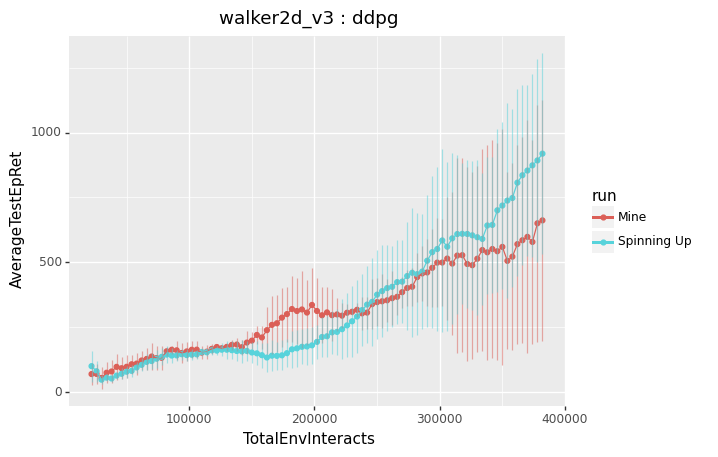

<ggplot: (-9223363245148595112)>

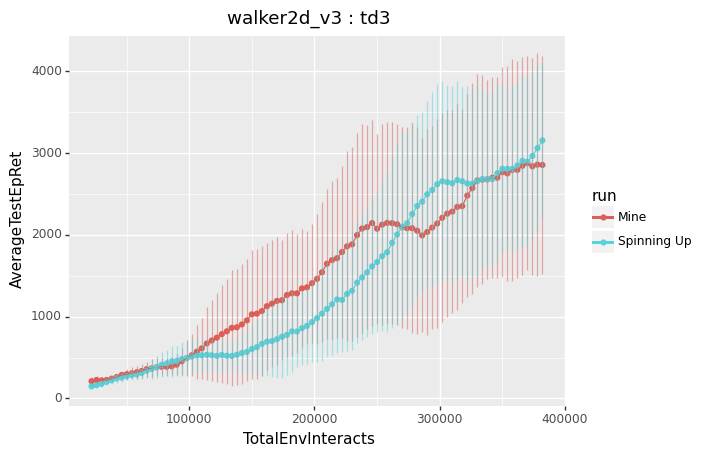

<ggplot: (-9223363245148595112)>

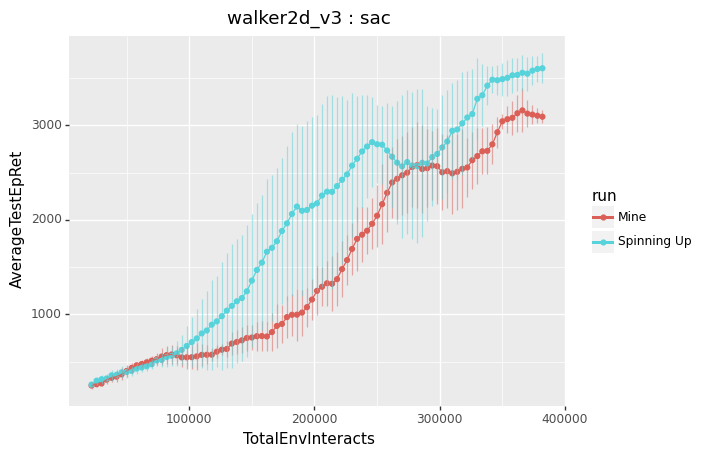

<ggplot: (8791563443390)>

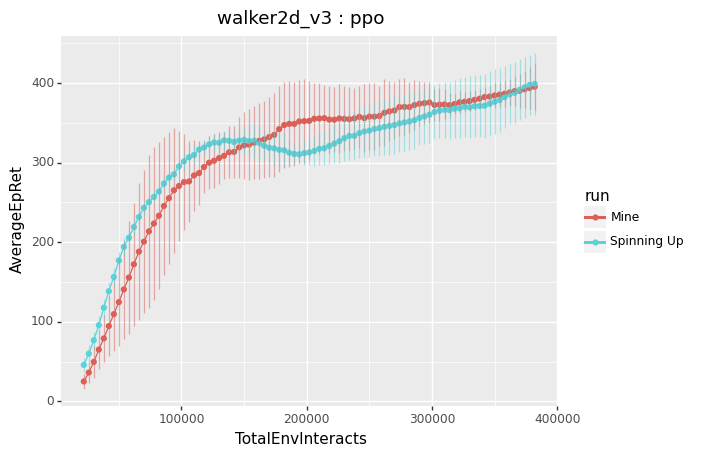

<ggplot: (-9223363245232447849)>

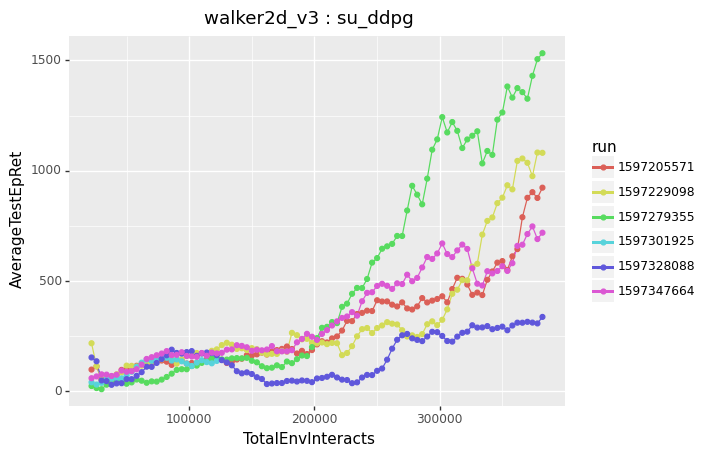

<ggplot: (-9223363245115101366)>

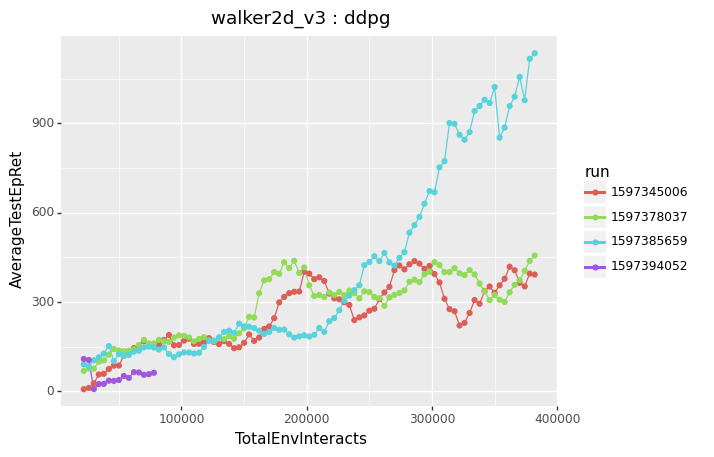

<ggplot: (-9223363245282738246)>

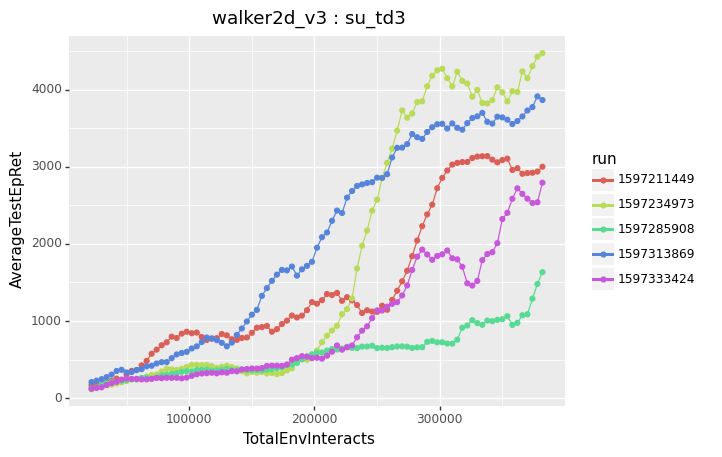

<ggplot: (-9223363245274260010)>

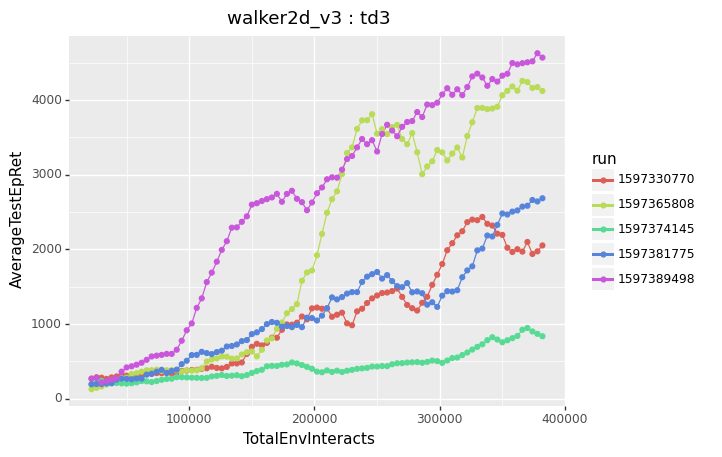

<ggplot: (8791655724331)>

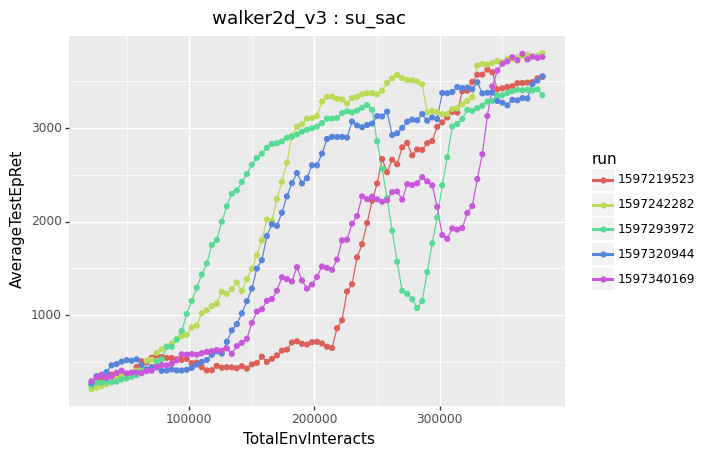

<ggplot: (-9223363245198980187)>

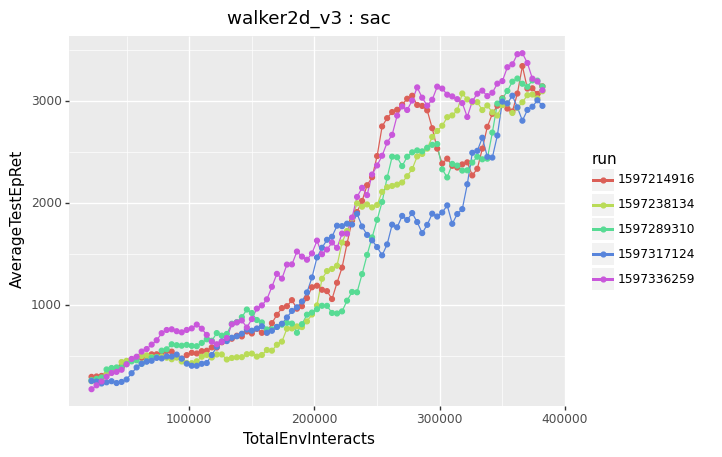

<ggplot: (-9223363245232672417)>

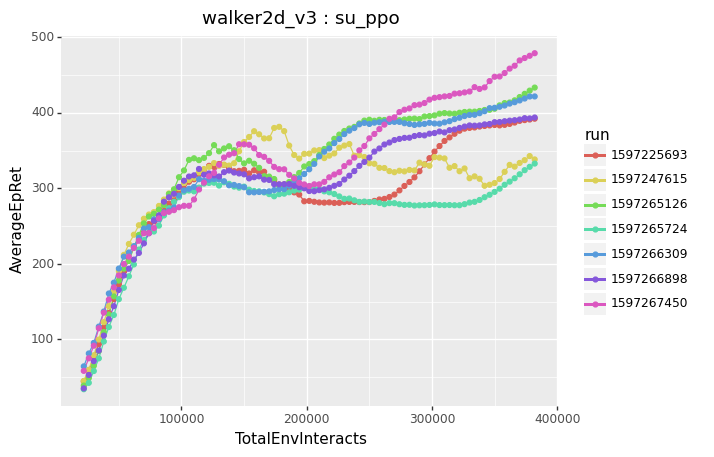

<ggplot: (8791580513649)>

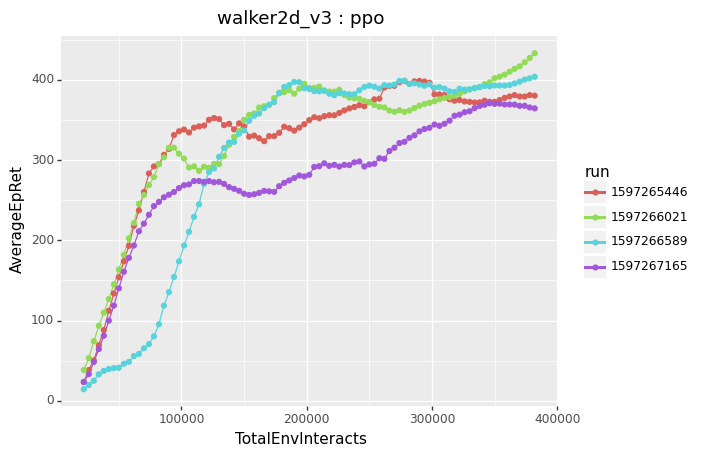

<ggplot: (-9223363245165354843)>

In [5]:
task = 'walker2d_v3'
window_size = 10
compare_all_methods(full_data, window_size=window_size)
plot_runs_all_methods(full_data, task, window_size=window_size)

/Users/kurtsmith/miniconda3/envs/spinningup/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 91 rows containing missing values.


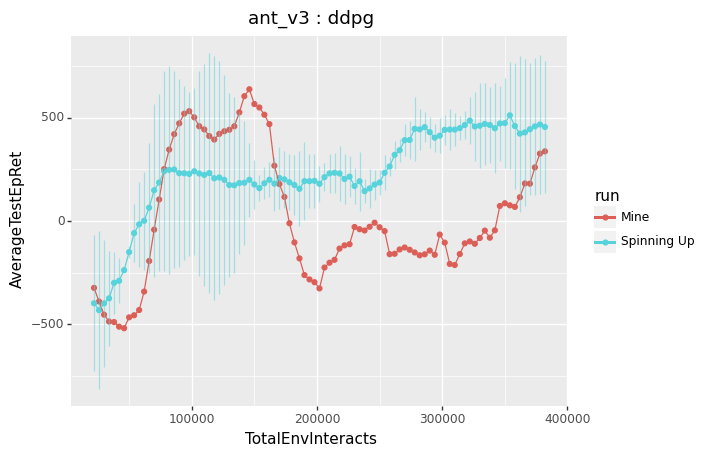

<ggplot: (8791622354152)>

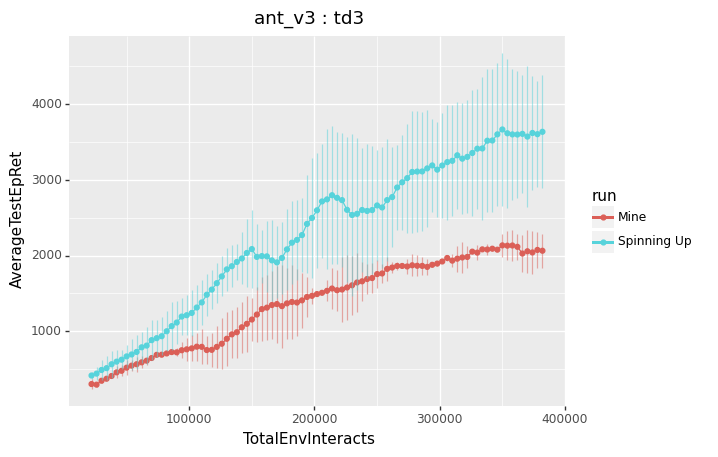

<ggplot: (-9223363245198996641)>

/Users/kurtsmith/miniconda3/envs/spinningup/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 121 rows containing missing values.


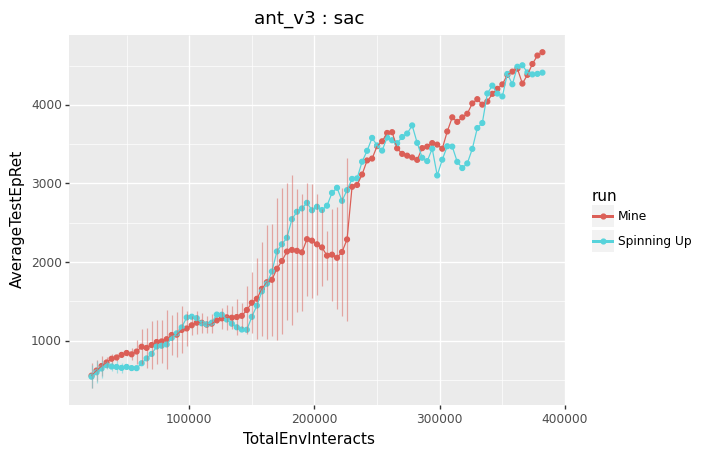

<ggplot: (8791622353686)>

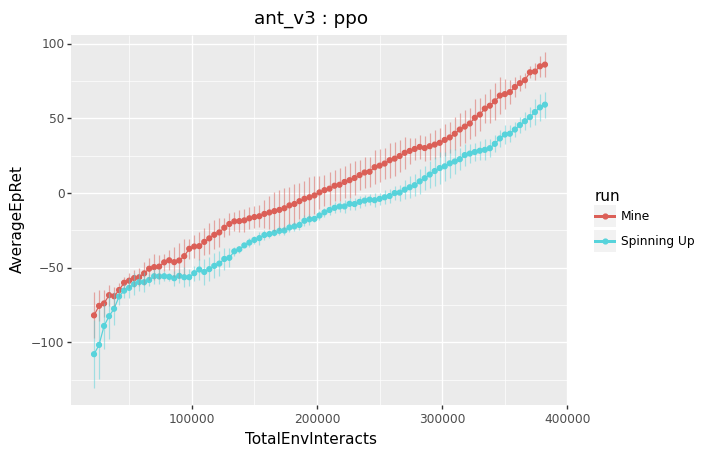

<ggplot: (8791622466431)>

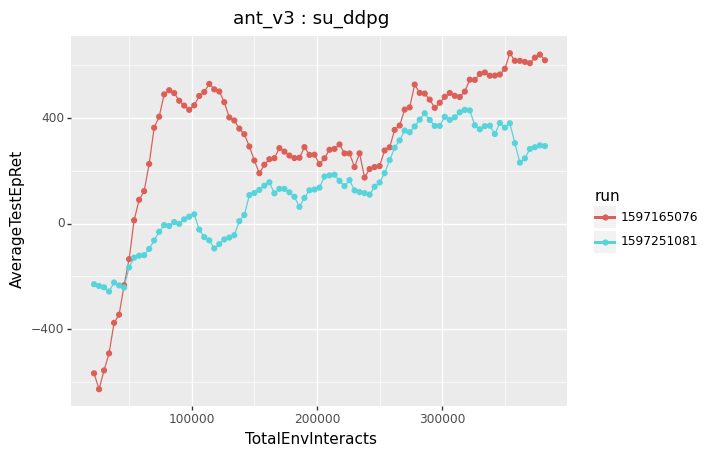

<ggplot: (8791622353777)>

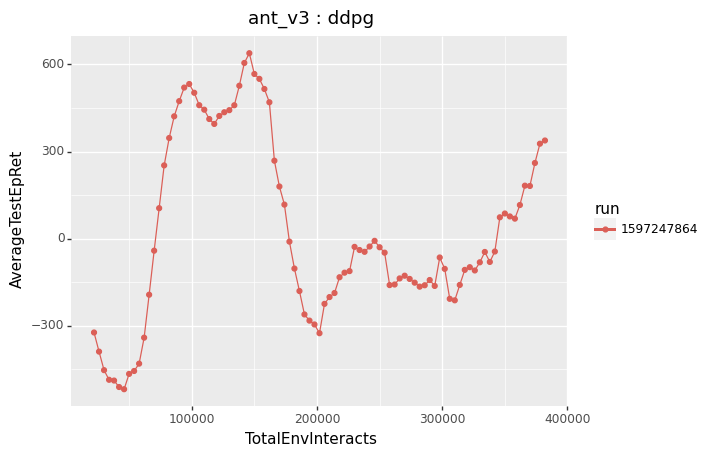

<ggplot: (8791756797490)>

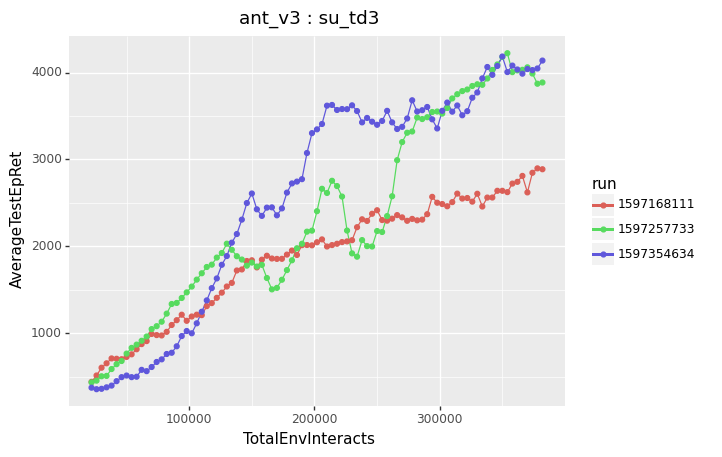

<ggplot: (-9223363245291408061)>

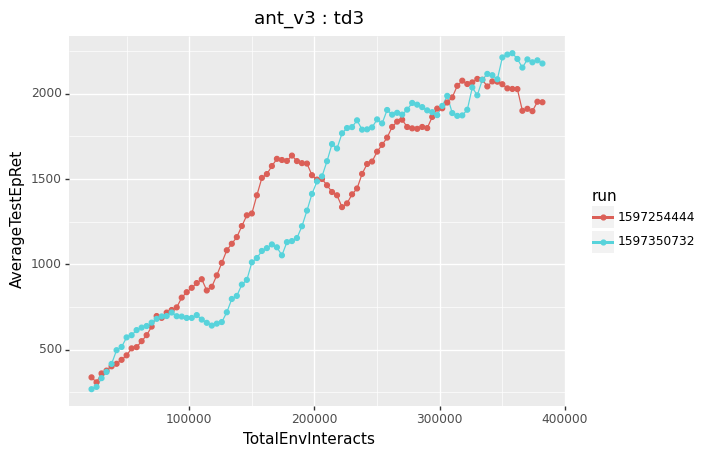

<ggplot: (-9223363245291408061)>

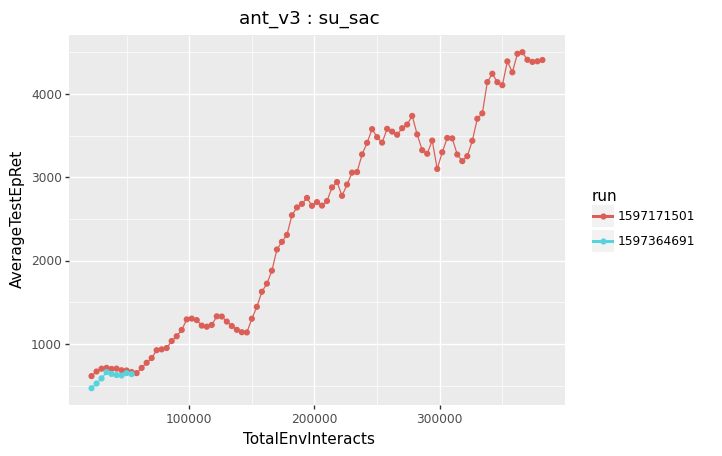

<ggplot: (-9223363245291408040)>

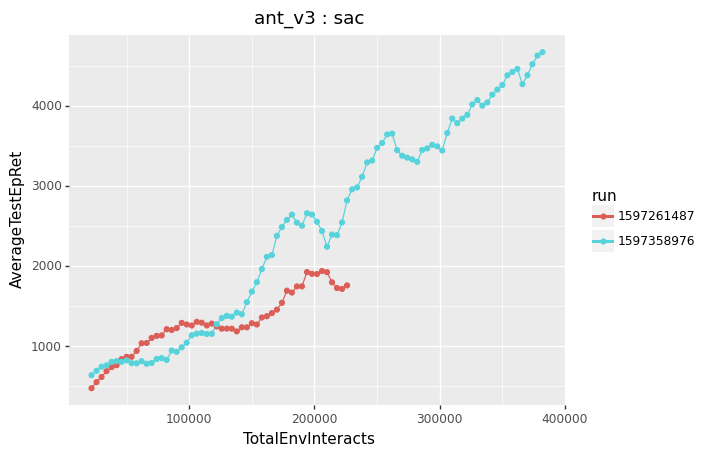

<ggplot: (-9223363245266072239)>

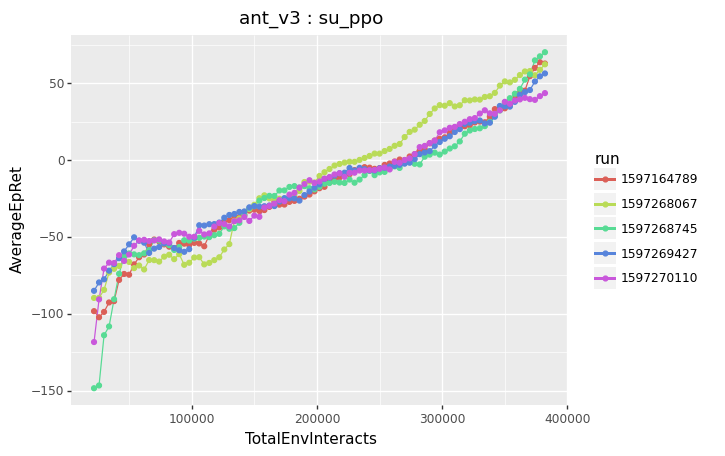

<ggplot: (-9223363245198996592)>

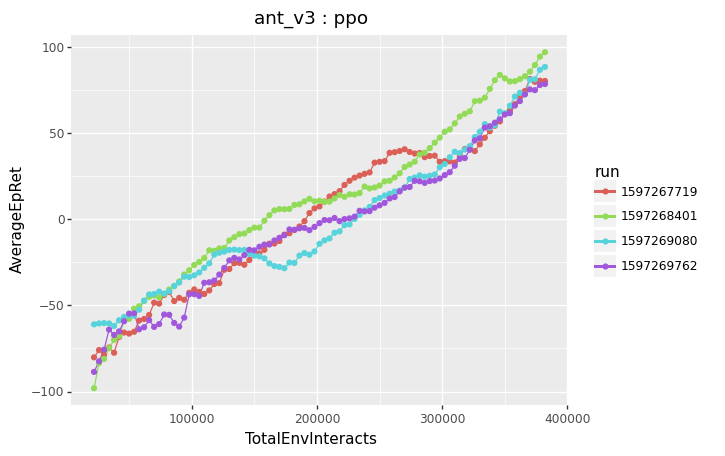

<ggplot: (-9223363245266109345)>

In [6]:
task = 'ant_v3'
window_size = 10
compare_all_methods(full_data, window_size=window_size)
plot_runs_all_methods(full_data, task, window_size=window_size)

/Users/kurtsmith/miniconda3/envs/spinningup/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 91 rows containing missing values.


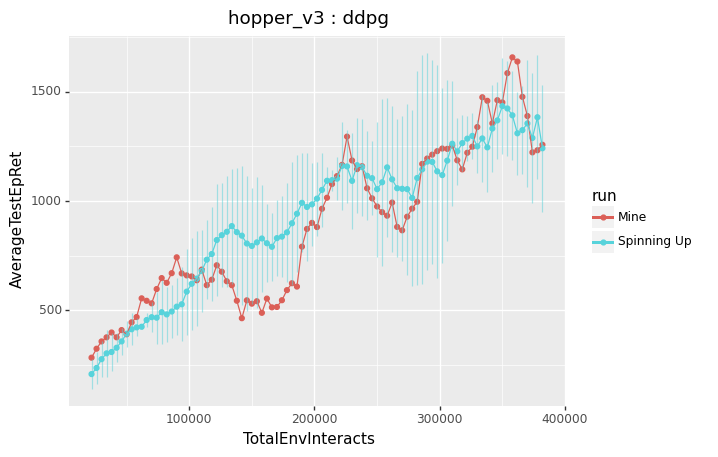

<ggplot: (8791655801050)>

/Users/kurtsmith/miniconda3/envs/spinningup/lib/python3.6/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 115 rows containing missing values.


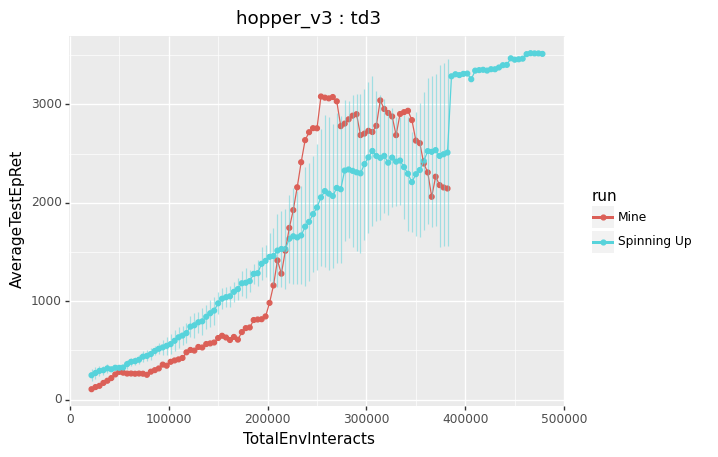

<ggplot: (-9223363245198974797)>

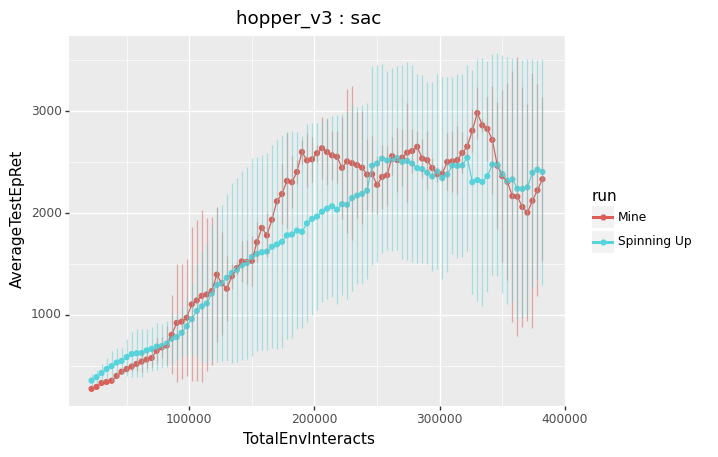

<ggplot: (8791655730040)>

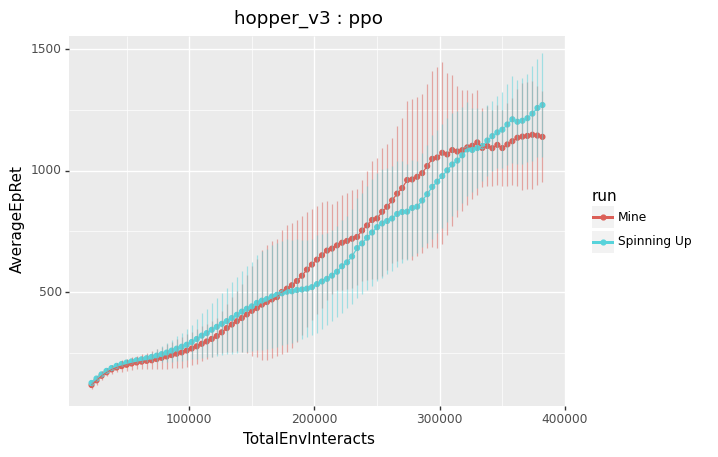

<ggplot: (8791655743026)>

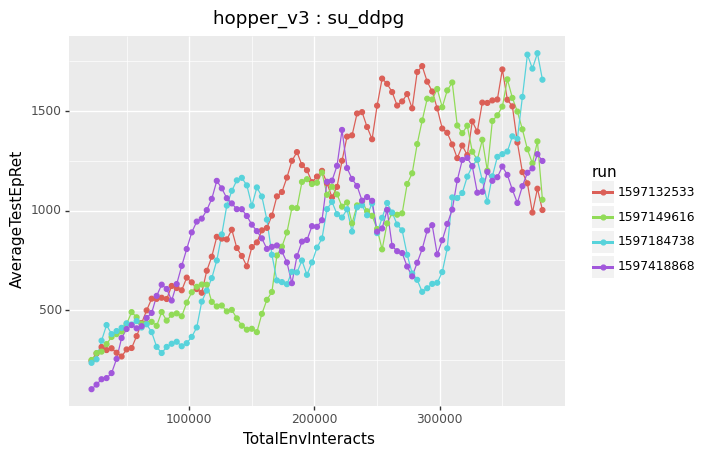

<ggplot: (8791580514673)>

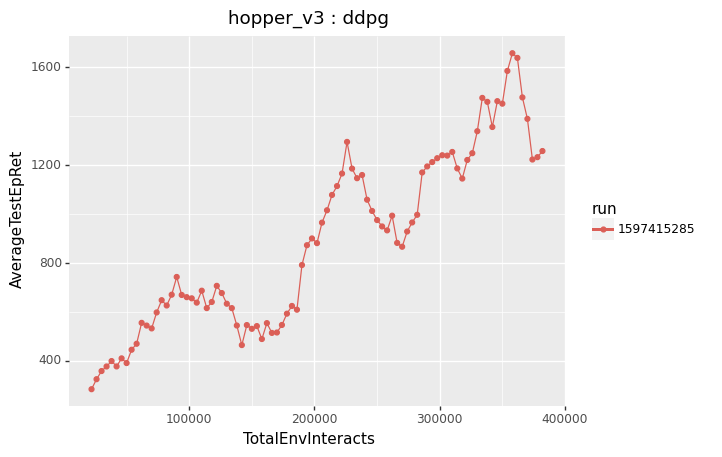

<ggplot: (8791655730131)>

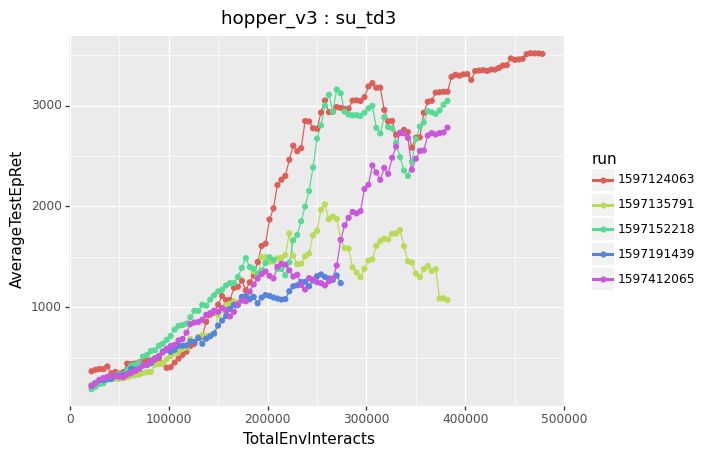

<ggplot: (-9223363245215728629)>

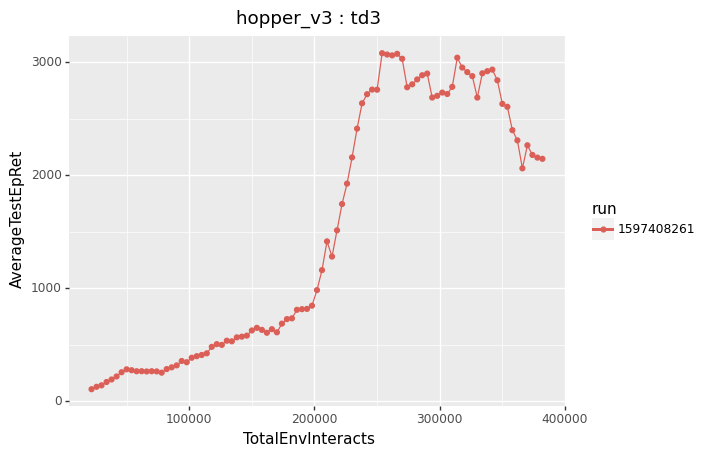

<ggplot: (8791655743026)>

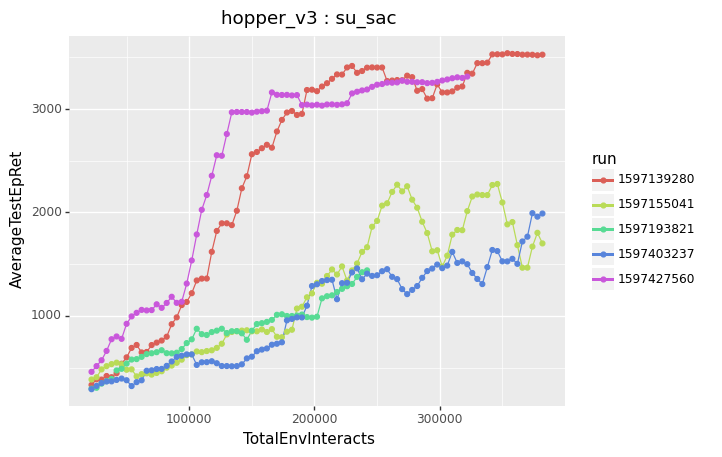

<ggplot: (-9223363245097967805)>

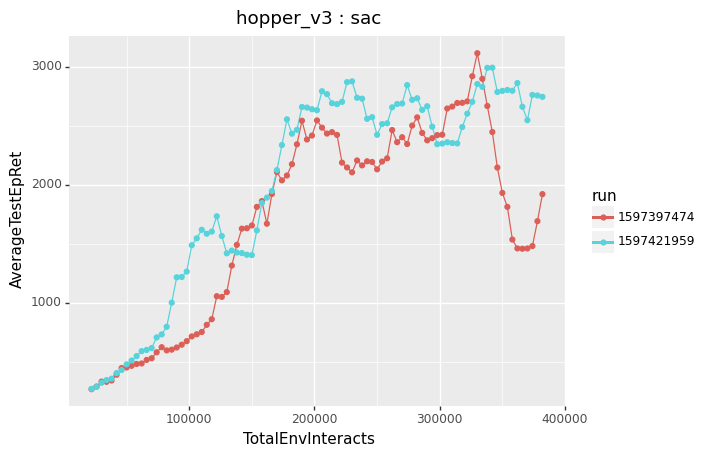

<ggplot: (-9223363245274262044)>

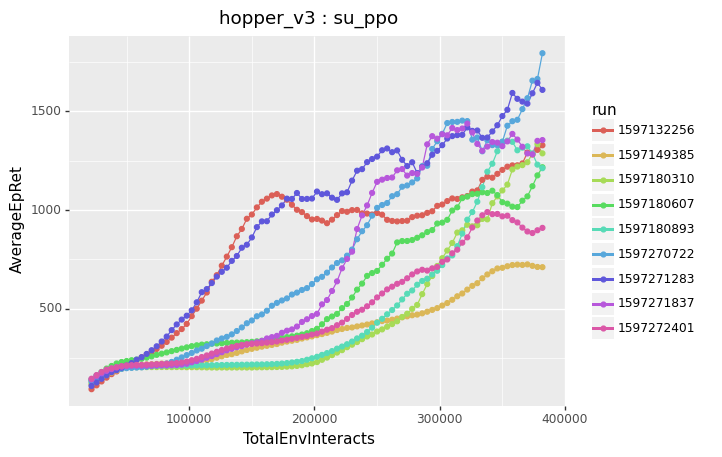

<ggplot: (8791655743180)>

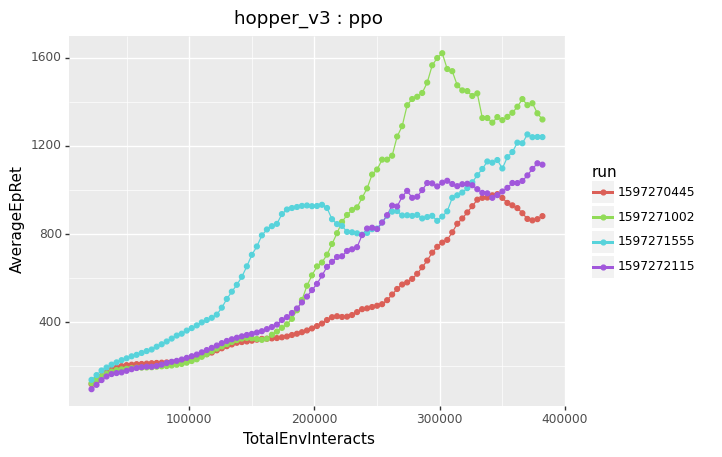

<ggplot: (8791655743229)>

In [7]:
task = 'hopper_v3'
window_size = 10
compare_all_methods(full_data, window_size=window_size)
plot_runs_all_methods(full_data, task, window_size=window_size)

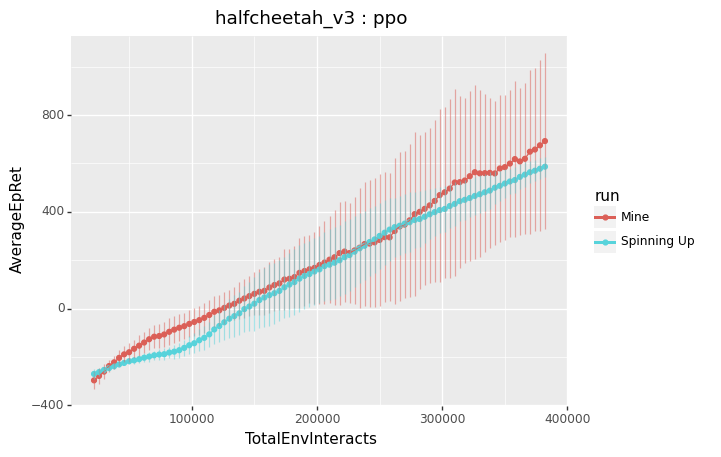

<ggplot: (8773687515603)>

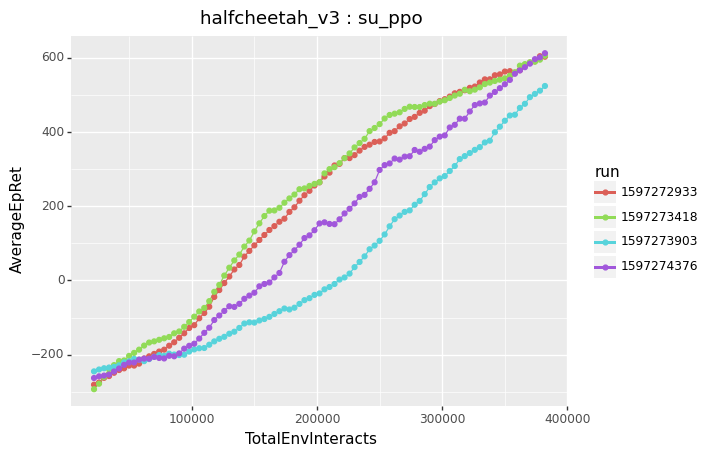

<ggplot: (-9223363263158646738)>

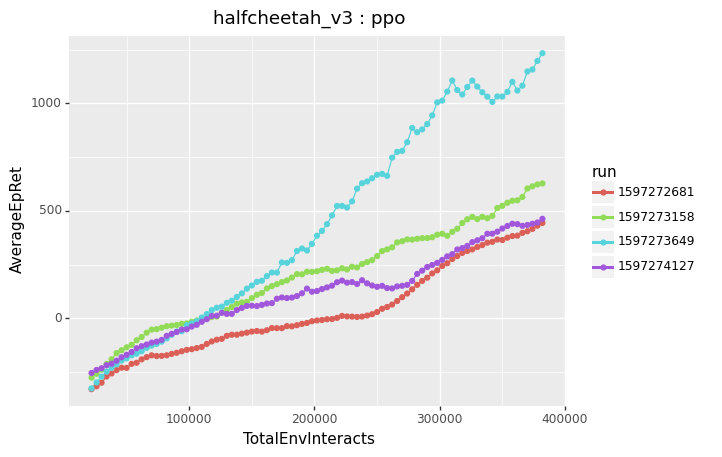

<ggplot: (8773687705762)>

In [1171]:
task = 'halfcheetah_v3'
window_size = 10
compare_all_methods(full_data, window_size=window_size)
plot_runs_all_methods(full_data, task, window_size=window_size)

In [1172]:
# task = 'walker2d_v3'
# compare_runs(task, points=True)
# compare_smoothed_returns(task)

******************************
walker2d_v3
******************************


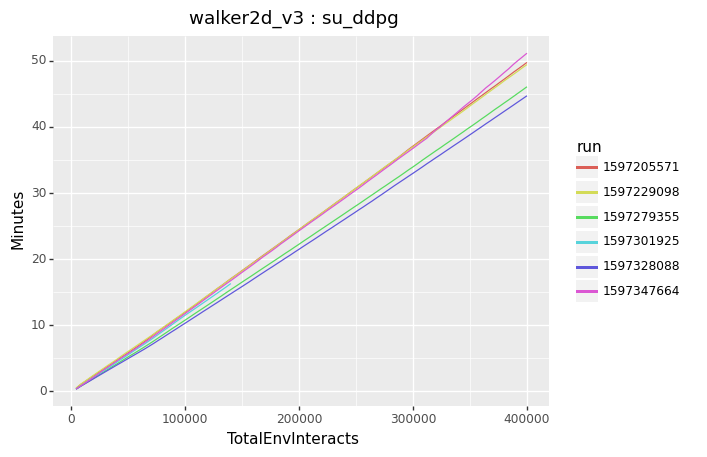

<ggplot: (-9223363245232422021)>

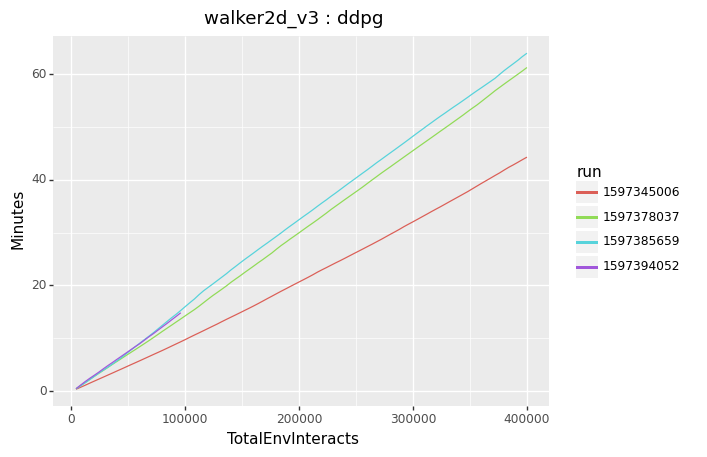

<ggplot: (8791639046699)>

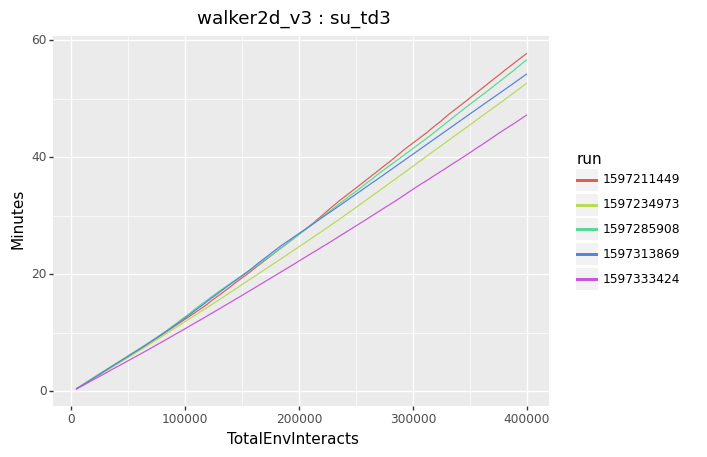

<ggplot: (8791706291604)>

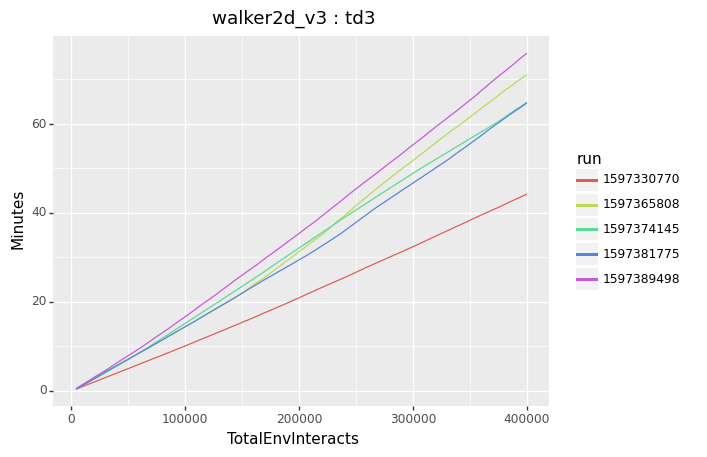

<ggplot: (8791706291625)>

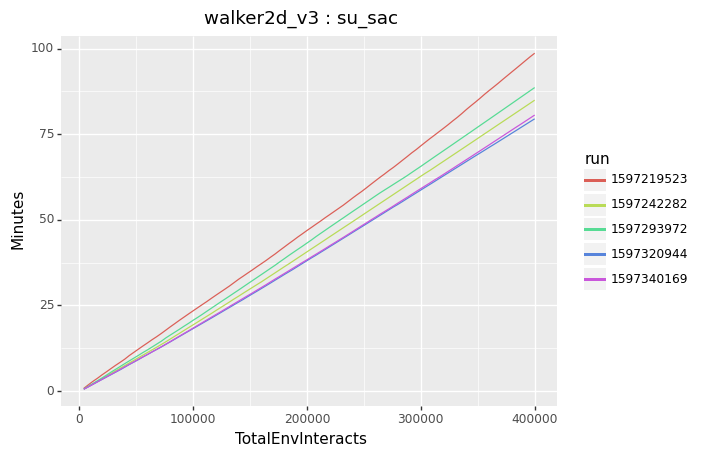

<ggplot: (8791706291625)>

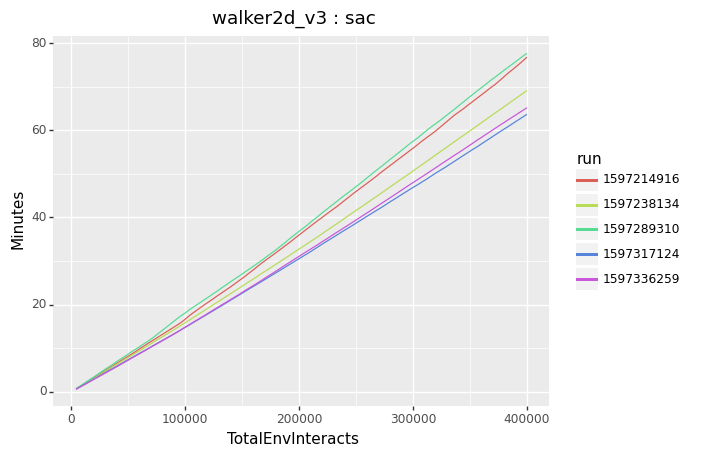

<ggplot: (-9223363245165345781)>

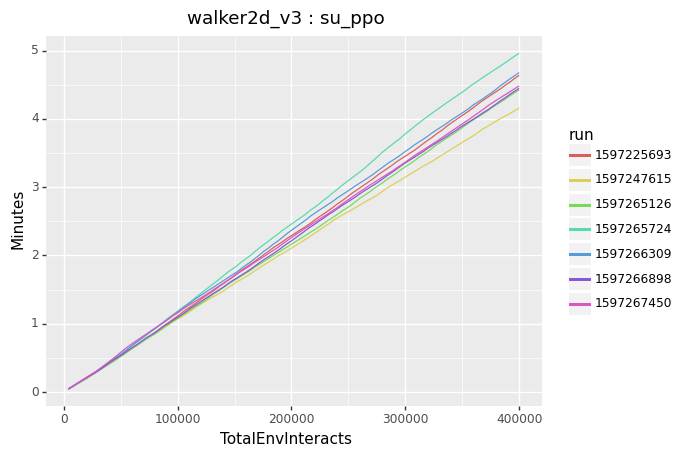

<ggplot: (8791756817093)>

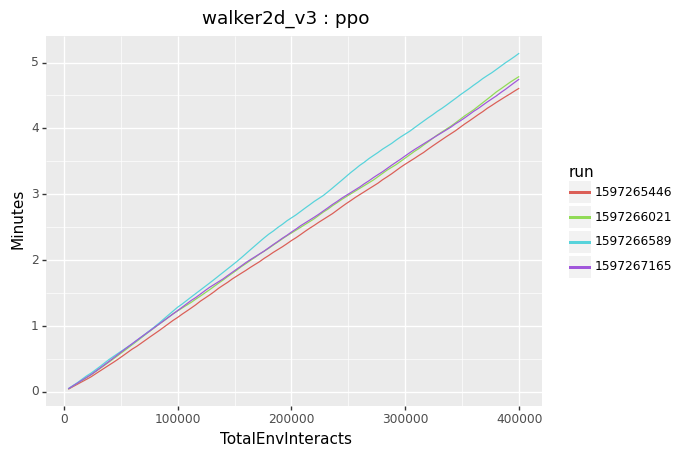

<ggplot: (8791655795513)>

******************************
ant_v3
******************************


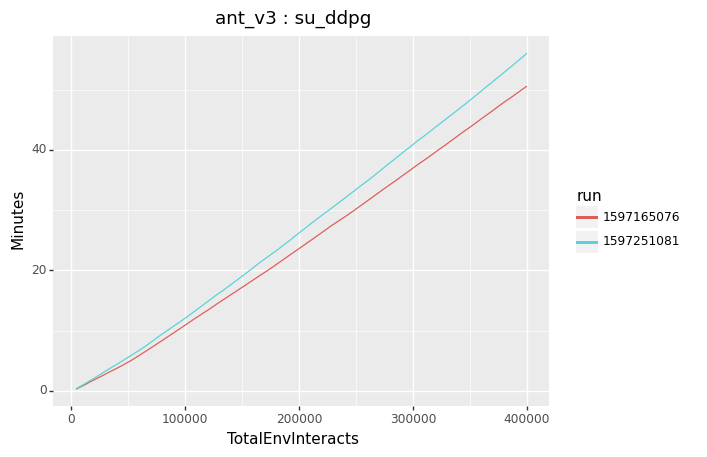

<ggplot: (8791756803802)>

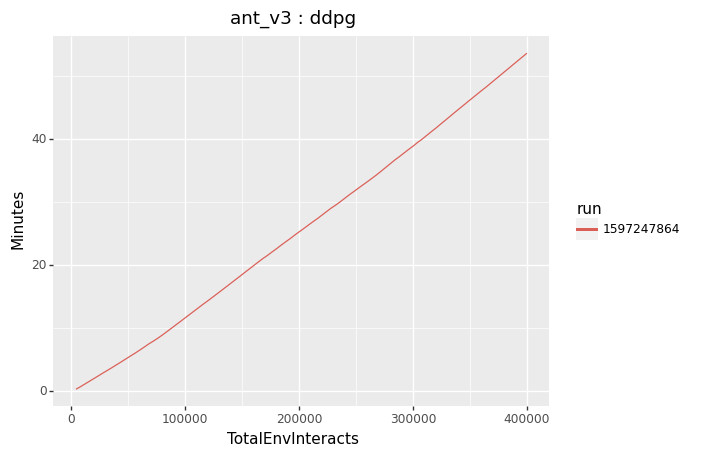

<ggplot: (8791672530871)>

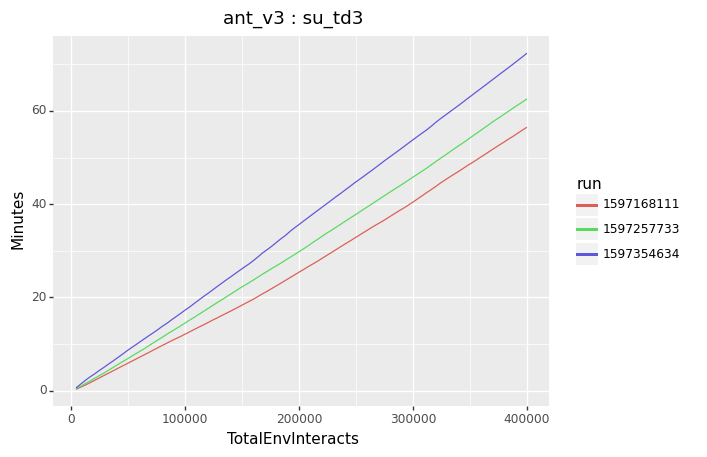

<ggplot: (8791588652103)>

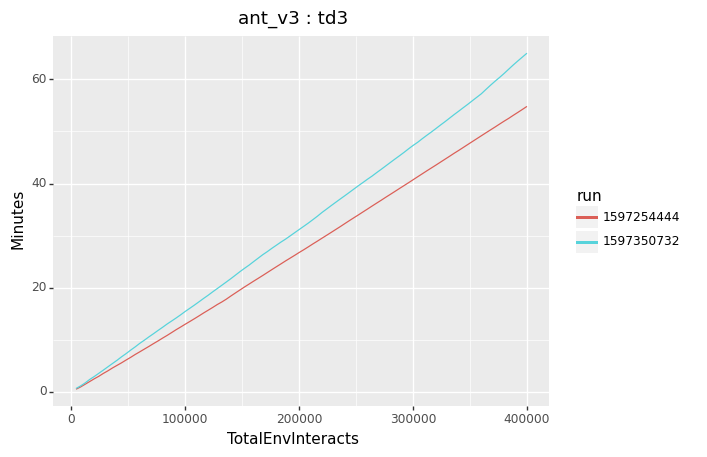

<ggplot: (-9223363245098081718)>

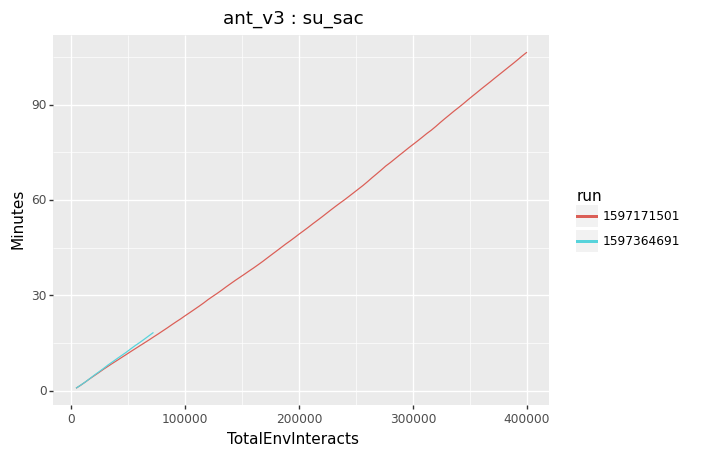

<ggplot: (8791563447560)>

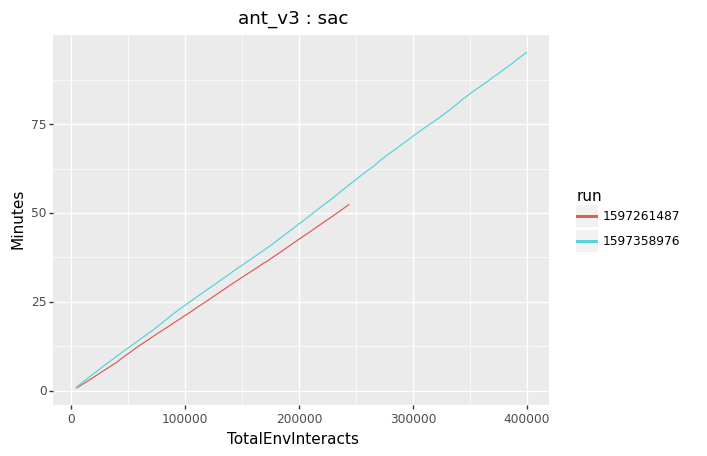

<ggplot: (8791756803802)>

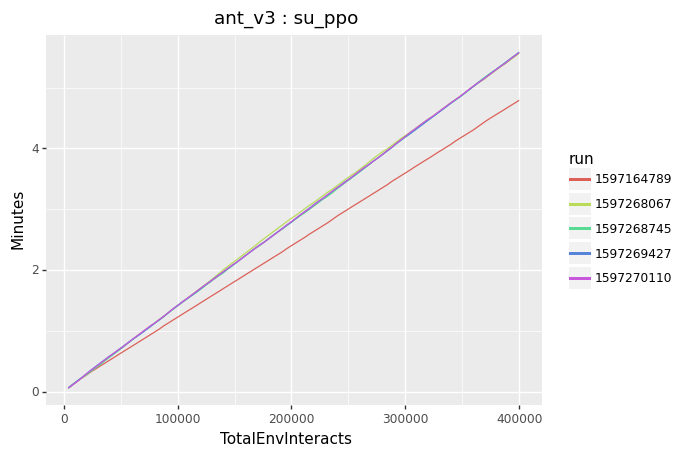

<ggplot: (-9223363245266061715)>

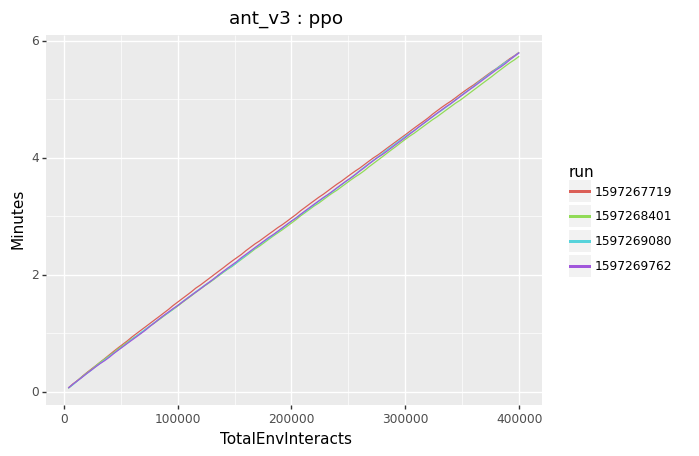

<ggplot: (-9223363245097972206)>

******************************
hopper_v3
******************************


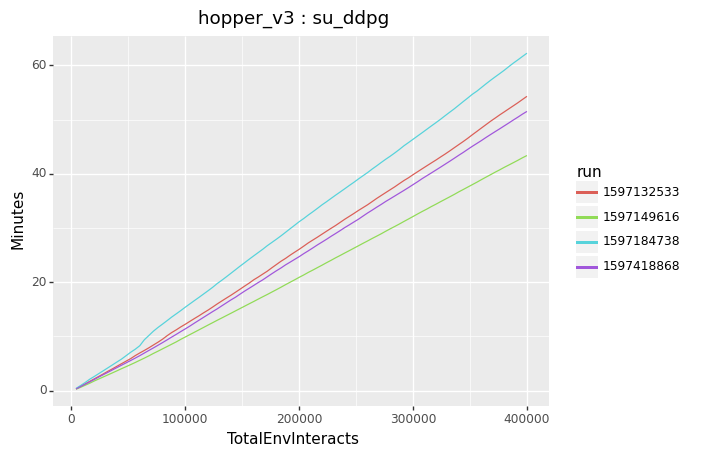

<ggplot: (-9223363245199059084)>

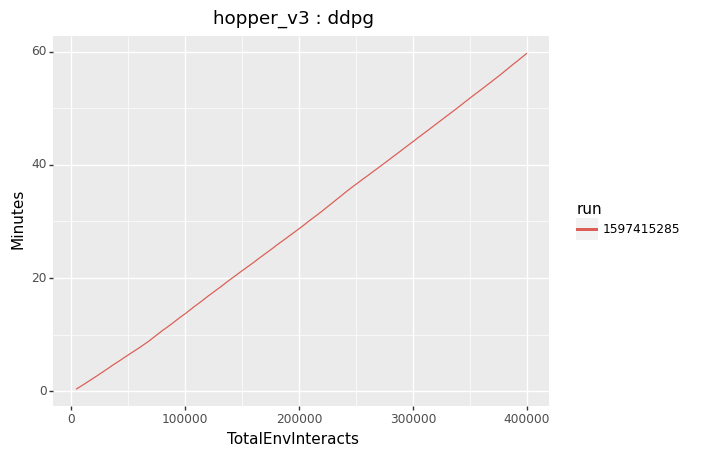

<ggplot: (8791572019990)>

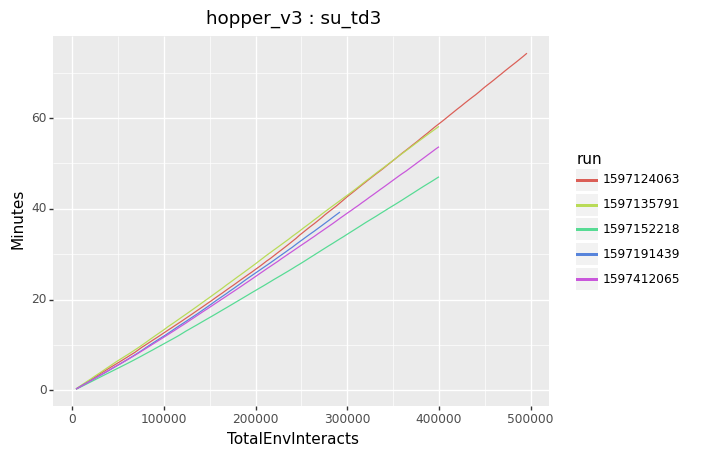

<ggplot: (8791572020593)>

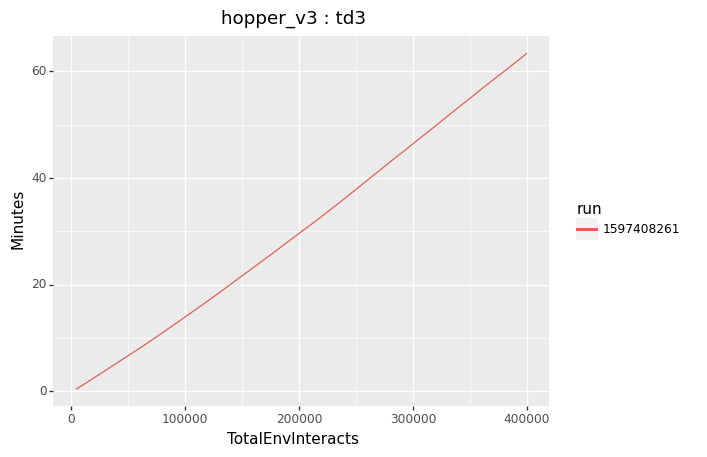

<ggplot: (8791639056918)>

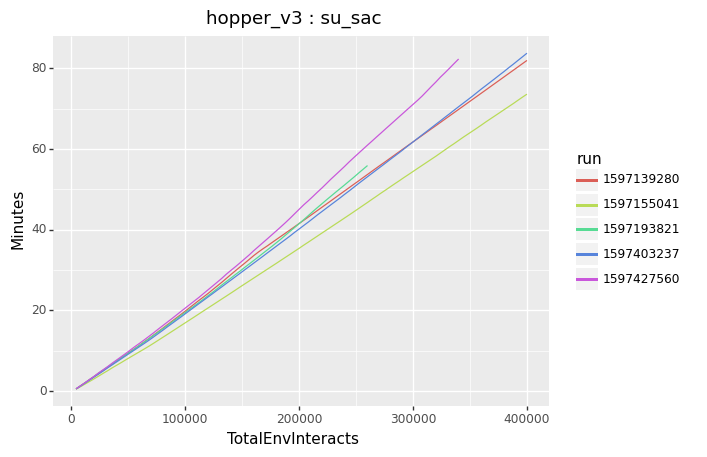

<ggplot: (-9223363245199045316)>

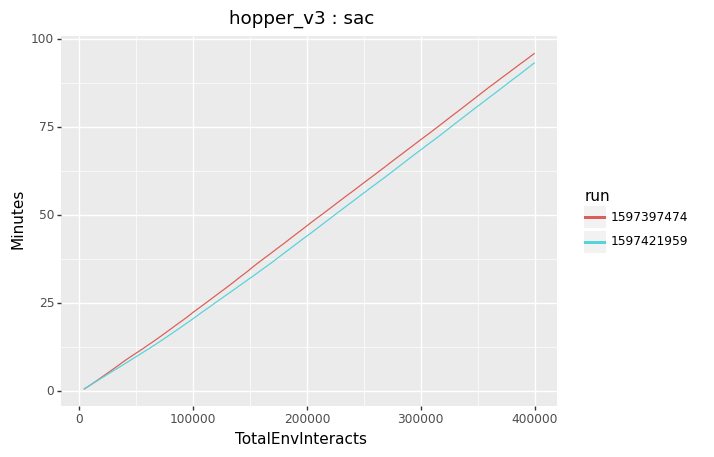

<ggplot: (8791622315433)>

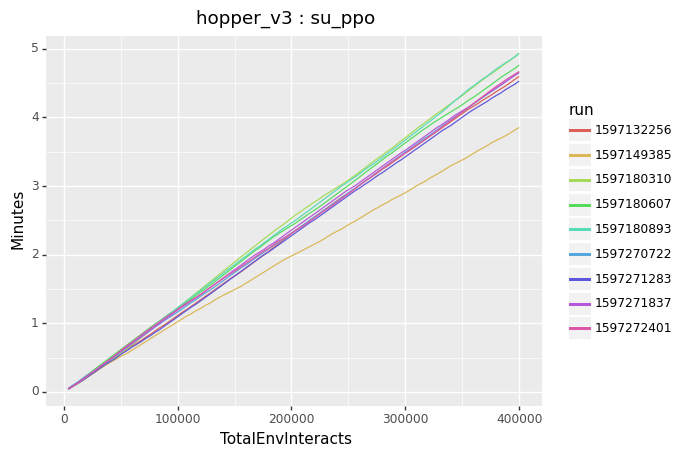

<ggplot: (-9223363245274270092)>

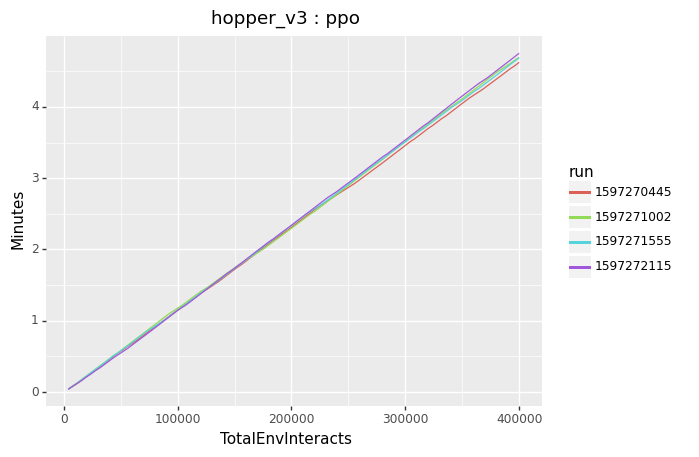

<ggplot: (8791622315433)>

******************************
halfcheetah_v3
******************************


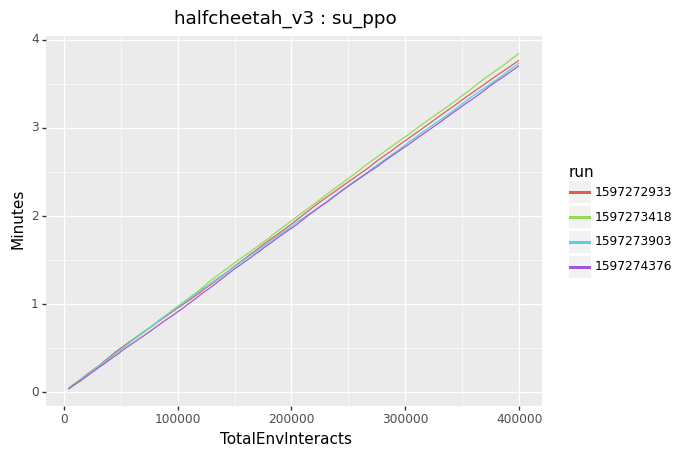

<ggplot: (-9223363245199032730)>

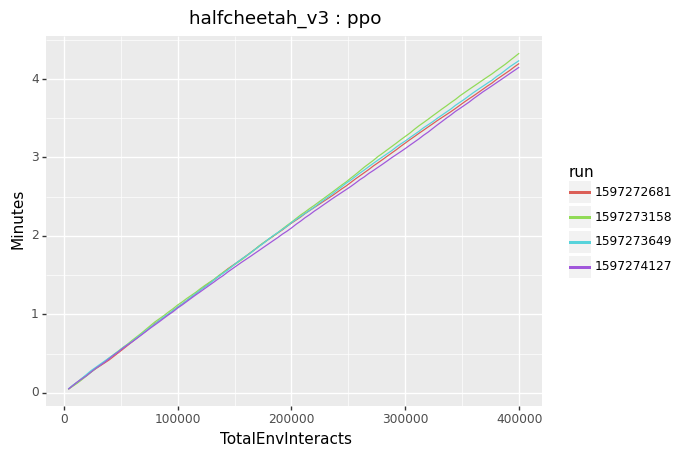

<ggplot: (-9223363245232310051)>

******************************
swimmer_v3
******************************


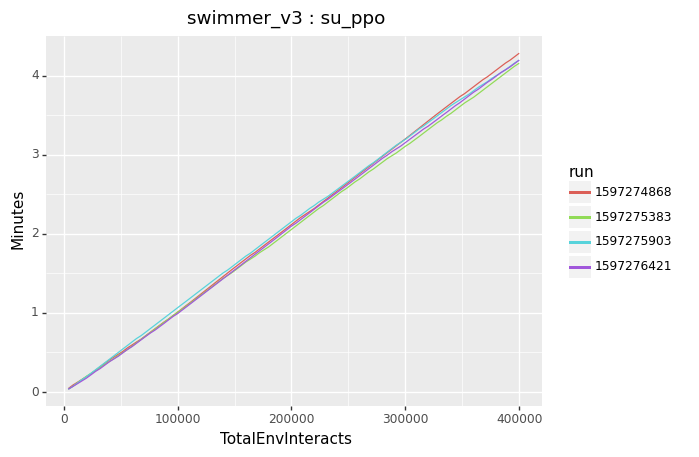

<ggplot: (-9223363245199034382)>

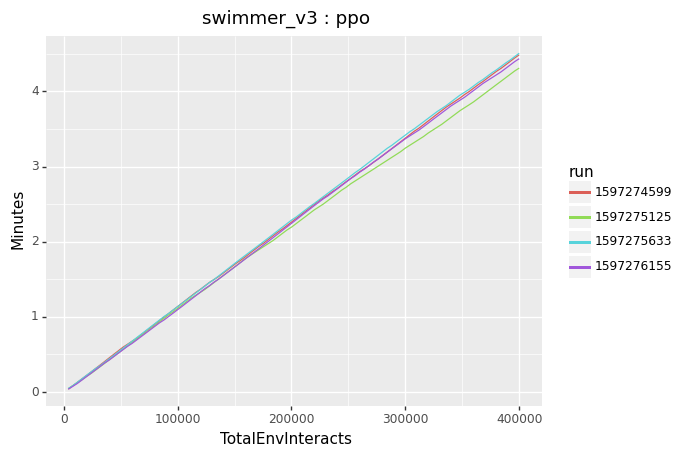

<ggplot: (-9223363245232310065)>

In [8]:
for task in task_list:
    print('******************************')
    print(task)
    print('******************************')
    plot_runs_all_methods(full_data, task, col='Minutes', points=False)

In [1174]:
# task = 'walker2d_v3'
# col = 'StdEpRet'
# compare_runs(task, points=True, col=col)
# compare_smoothed_returns(task, col=col)

In [1175]:
# task = 'walker2d_v3'
# compare_runs(task, points=True, full_data=full_data_64)
# compare_smoothed_returns(task, full_data=full_data_64)